# Creating the boundary forcing

In [1]:
from roms_tools import Grid

We start by creating a grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, atmospheric forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here, we use the following grid with the default parameters for the vertical coordinate system.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

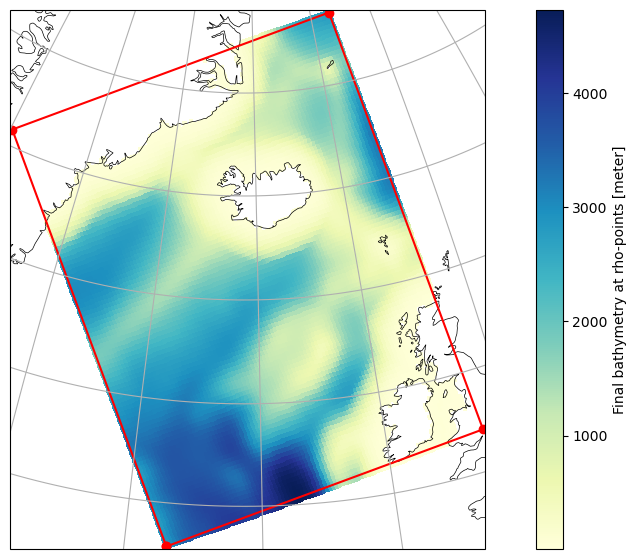

In [3]:
grid.plot(bathymetry=True)

## Physical boundary forcing from GLORYS
In this section, we use GLORYS data to create our physical boundary forcing, i.e., temperature, salinity, sea surface height, and velocities. (We will learn how to create biogeochemical initial conditions further down in the notebook.) 

Say we want to get boundary forcing from January 2, 2012 to January 3, 2012.

In [4]:
from datetime import datetime

In [5]:
start_time = datetime(2012, 1, 2)
end_time = datetime(2012, 1, 4)

Our GLORYS data for that day sits at the following path.

In [6]:
path = "/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc"

We can now create the `BoundaryForcing` object.

In [7]:
from roms_tools import BoundaryForcing

In [8]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "GLORYS", "path": path},
)

CPU times: user 16.7 s, sys: 985 ms, total: 17.7 s
Wall time: 39 s


The boundary forcing variables are held in a DataTree that is accessible via the `.ds` property.

In [9]:
boundary_forcing.ds

DataTree('root', parent=None)
│   Dimensions:  (s_rho: 100)
│   Dimensions without coordinates: s_rho
│   Data variables:
│       sc_r     (s_rho) float32 400B -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
│       Cs_r     (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
│   Attributes:
│       title:                 ROMS boundary forcing file created by ROMS-Tools
│       roms_tools_version:    0.1.dev73+dirty
│       start_time:            2012-01-02 00:00:00
│       end_time:              2012-01-04 00:00:00
│       model_reference_date:  2000-01-01 00:00:00
│       theta_s:               5.0
│       theta_b:               2.0
│       hc:                    300.0
└── DataTree('physics')
        Dimensions:     (bry_time: 2, xi_rho: 102, s_rho: 100, xi_u: 101, eta_rho: 102,
                         eta_v: 101)
        Coordinates:
            abs_time    (bry_time) datetime64[ns] 16B 2012-01-02T12:00:00 2012-01-03T...
          * bry_time    (bry_time) timedelta64[ns] 16B 4384 days 12:00:00 4385 days 1...
        Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
        Data variables: (12/28)
            zeta_south  (bry_time, xi_rho) float32 816B dask.array<chunksize=(1, 102), meta=np.ndarray>
            temp_south  (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
            salt_south  (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
            u_south     (bry_time, s_rho, xi_u) float32 81kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
            v_south     (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
            ubar_south  (bry_time, xi_u) float32 808B dask.array<chunksize=(1, 101), meta=np.ndarray>
            ...          ...
            temp_west   (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
            salt_west   (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
            u_west      (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
            v_west      (bry_time, s_rho, eta_v) float32 81kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
            ubar_west   (bry_time, eta_rho) float32 816B dask.array<chunksize=(1, 102), meta=np.ndarray>
            vbar_west   (bry_time, eta_v) float32 808B dask.array<chunksize=(1, 101), meta=np.ndarray>
        Attributes:
            title:                 ROMS boundary forcing file created by ROMS-Tools
            roms_tools_version:    0.1.dev73+dirty
            start_time:            2012-01-02 00:00:00
            end_time:              2012-01-04 00:00:00
            model_reference_date:  2000-01-01 00:00:00
            theta_s:               5.0
            theta_b:               2.0
            hc:                    300.0
            physics_source:        GLORYS

The DataTree has a group `physics` with all the physical boundary forcing variables.

In [10]:
boundary_forcing.ds["physics"]

DataTree('physics', parent="root")
    Dimensions:     (bry_time: 2, xi_rho: 102, s_rho: 100, xi_u: 101, eta_rho: 102,
                     eta_v: 101)
    Coordinates:
        abs_time    (bry_time) datetime64[ns] 16B 2012-01-02T12:00:00 2012-01-03T...
      * bry_time    (bry_time) timedelta64[ns] 16B 4384 days 12:00:00 4385 days 1...
    Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
    Data variables: (12/28)
        zeta_south  (bry_time, xi_rho) float32 816B dask.array<chunksize=(1, 102), meta=np.ndarray>
        temp_south  (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        salt_south  (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        u_south     (bry_time, s_rho, xi_u) float32 81kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
        v_south     (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        ubar_south  (bry_time, xi_u) float32 808B dask.array<chunksize=(1, 101), meta=np.ndarray>
        ...          ...
        temp_west   (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        salt_west   (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        u_west      (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        v_west      (bry_time, s_rho, eta_v) float32 81kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
        ubar_west   (bry_time, eta_rho) float32 816B dask.array<chunksize=(1, 102), meta=np.ndarray>
        vbar_west   (bry_time, eta_v) float32 808B dask.array<chunksize=(1, 101), meta=np.ndarray>
    Attributes:
        title:                 ROMS boundary forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-02 00:00:00
        end_time:              2012-01-04 00:00:00
        model_reference_date:  2000-01-01 00:00:00
        theta_s:               5.0
        theta_b:               2.0
        hc:                    300.0
        physics_source:        GLORYS

You can see that all boundary forcing variables are Dask arrays, so these fields have not been actually computed yet. Full computation will not be triggered until the `.plot` or `.save` methods are called.

## Plotting

Let's make some plots! As an example, let's have a look at the zonal velocity field `u` at the southern and western boundaries.

In [11]:
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 126.23 s
CPU times: user 58.2 s, sys: 1.09 s, total: 59.3 s
Wall time: 2min 6s


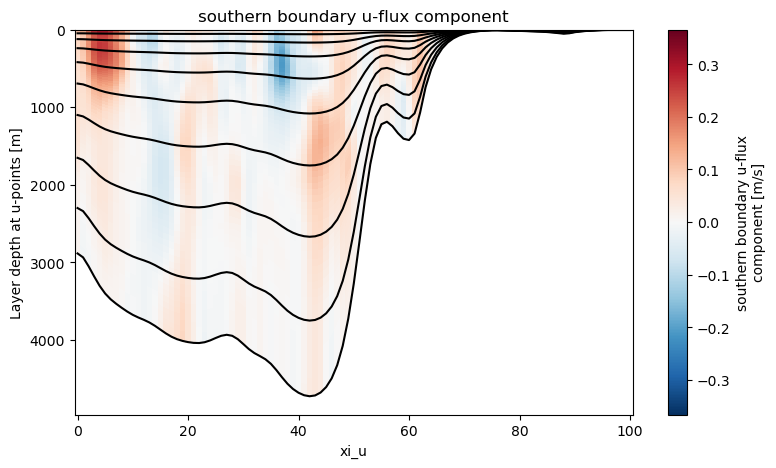

In [12]:
with ProgressBar():
    %time boundary_forcing.plot("u_south", time=0, layer_contours=True)

[########################################] | 100% Completed | 125.79 s
CPU times: user 58.1 s, sys: 1.04 s, total: 59.2 s
Wall time: 2min 5s


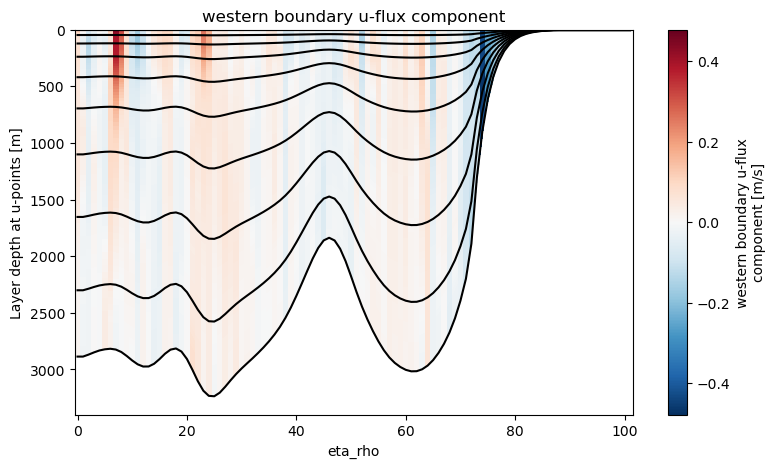

In [13]:
with ProgressBar():
    %time boundary_forcing.plot("u_west", time=0, layer_contours=True)

Sea surface height `zeta` at any of the boundaries and for a specific time is only a 1D variable.

[########################################] | 100% Completed | 2.18 sms
CPU times: user 946 ms, sys: 10.6 ms, total: 956 ms
Wall time: 2.23 s


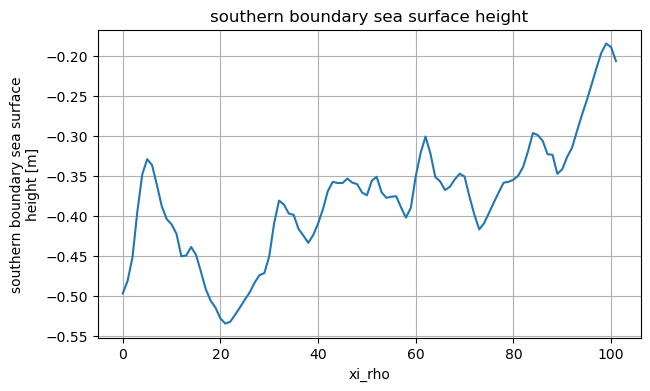

In [14]:
with ProgressBar():
    %time boundary_forcing.plot("zeta_south", time=0)

The same is true for the barotropic velocity `ubar`.

[########################################] | 100% Completed | 120.25 s
CPU times: user 55.6 s, sys: 933 ms, total: 56.6 s
Wall time: 2min


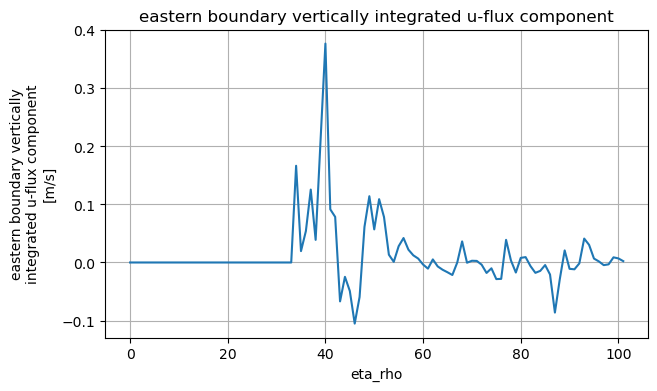

In [15]:
with ProgressBar():
    %time boundary_forcing.plot("ubar_east", time=0)

## Adding BGC boundary forcing
We now create boundary forcing that include both physical variables (again from GLORYS) and biogeochemical (BGC) variables. The BGC variables are taken from a CESM climatology, which is located here.

In [16]:
bgc_path = "/glade/derecho/scratch/noraloose/roms-tools-data/BGC/CESM-climatology_lowres_regridded.nc"

The boundary forcing is created as above, but now with additional information about the `bgc_source`.

In [17]:
%%time

boundary_forcing_with_bgc = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "GLORYS", "path": path},
    bgc_source={"name": "CESM_REGRIDDED", "path": bgc_path, "climatology": True},
)

CPU times: user 9.83 s, sys: 239 ms, total: 10.1 s
Wall time: 21.7 s


The DataTree accessible via the `.ds` property now has two groups -- `physics` and `bgc` -- with the corresponding boundary forcing variables.

In [18]:
boundary_forcing_with_bgc.ds["physics"]

DataTree('physics', parent="root")
    Dimensions:     (bry_time: 2, xi_rho: 102, s_rho: 100, xi_u: 101, eta_rho: 102,
                     eta_v: 101)
    Coordinates:
        abs_time    (bry_time) datetime64[ns] 16B 2012-01-02T12:00:00 2012-01-03T...
      * bry_time    (bry_time) timedelta64[ns] 16B 4384 days 12:00:00 4385 days 1...
    Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
    Data variables: (12/28)
        zeta_south  (bry_time, xi_rho) float32 816B dask.array<chunksize=(1, 102), meta=np.ndarray>
        temp_south  (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        salt_south  (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        u_south     (bry_time, s_rho, xi_u) float32 81kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
        v_south     (bry_time, s_rho, xi_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        ubar_south  (bry_time, xi_u) float32 808B dask.array<chunksize=(1, 101), meta=np.ndarray>
        ...          ...
        temp_west   (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        salt_west   (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        u_west      (bry_time, s_rho, eta_rho) float32 82kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
        v_west      (bry_time, s_rho, eta_v) float32 81kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
        ubar_west   (bry_time, eta_rho) float32 816B dask.array<chunksize=(1, 102), meta=np.ndarray>
        vbar_west   (bry_time, eta_v) float32 808B dask.array<chunksize=(1, 101), meta=np.ndarray>
    Attributes:
        title:                 ROMS boundary forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-02 00:00:00
        end_time:              2012-01-04 00:00:00
        model_reference_date:  2000-01-01 00:00:00
        theta_s:               5.0
        theta_b:               2.0
        hc:                    300.0
        physics_source:        GLORYS

In [19]:
boundary_forcing_with_bgc.ds["bgc"]

DataTree('bgc', parent="root")
    Dimensions:            (bry_time: 12, s_rho: 100, xi_rho: 102, eta_rho: 102)
    Coordinates:
        abs_time           (bry_time) timedelta64[ns] 96B 15 days ... 349 days
      * bry_time           (bry_time) timedelta64[ns] 96B 15 days ... 349 days
    Dimensions without coordinates: s_rho, xi_rho, eta_rho
    Data variables: (12/128)
        PO4_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        NO3_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        SiO3_south         (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        NH4_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        Fe_south           (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        Lig_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        ...                 ...
        diazChl_west       (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        diazC_west         (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        diazP_west         (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        diazFe_west        (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        spCaCO3_west       (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
        zooC_west          (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    Attributes:
        title:                 ROMS boundary forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-02 00:00:00
        end_time:              2012-01-04 00:00:00
        model_reference_date:  2000-01-01 00:00:00
        theta_s:               5.0
        theta_b:               2.0
        hc:                    300.0
        bgc_source:            CESM_REGRIDDED

Note that the time variables in `boundary_forcing_with_bgc.ds["physics"]` and `boundary_forcing_with_bgc.ds["bgc"]` differ, as seen in the two following cells.

In [20]:
boundary_forcing_with_bgc.ds["physics"]["bry_time"]

<xarray.DataArray 'bry_time' (bry_time: 2)> Size: 16B
array([378820800000000000, 378907200000000000], dtype='timedelta64[ns]')
Coordinates:
    abs_time  (bry_time) datetime64[ns] 16B 2012-01-02T12:00:00 2012-01-03T12...
  * bry_time  (bry_time) timedelta64[ns] 16B 4384 days 12:00:00 4385 days 12:...
Attributes:
    long_name:  nanoseconds since 2000-01-01T00:00:00.000000000

In [21]:
boundary_forcing_with_bgc.ds["bgc"]["bry_time"]

<xarray.DataArray 'bry_time' (bry_time: 12)> Size: 96B
array([ 1296000000000000,  3888000000000000,  6393600000000000,
        9072000000000000, 11664000000000000, 14342400000000000,
       16934400000000000, 19612800000000000, 22291200000000000,
       24883200000000000, 27561600000000000, 30153600000000000],
      dtype='timedelta64[ns]')
Coordinates:
    abs_time  (bry_time) timedelta64[ns] 96B 15 days 45 days ... 349 days
  * bry_time  (bry_time) timedelta64[ns] 96B 15 days 45 days ... 349 days
Attributes:
    long_name:     nanoseconds since 2000-01-01T00:00:00.000000000
    cycle_length:  365.25

* `boundary_forcing_with_bgc.ds["physics"]` has two time entries since we asked for times between January 2 and January 4 in 2012 and the provided data in `physics_source={"name": "GLORYS", "path": path}` has daily data.
* `boundary_forcing_with_bgc.ds["bgc"]` has twelve time entries because the data in `bgc_source={"name": "CESM_REGRIDDED", "path": bgc_path, "climatology": True}` is a climatology. For climatologies, `ROMS-Tools` does not subsample the twelve time entries further, regardless of the provided start and end time. Note that the `bry_time` coordinate has an additional attribute: `cycle_length` (with units in days). This attribute will tell ROMS to repeat the climatology every 365.25 days. In other words, the data in `bdry_forcing.ds["bgc"]` will work for ROMS run over any time window (as long as the model reference date is January 1, 2000).

We can plot both physical and BGC boundary forcing as we saw above.

[########################################] | 100% Completed | 5.67 sms
CPU times: user 1.99 s, sys: 713 ms, total: 2.71 s
Wall time: 5.71 s


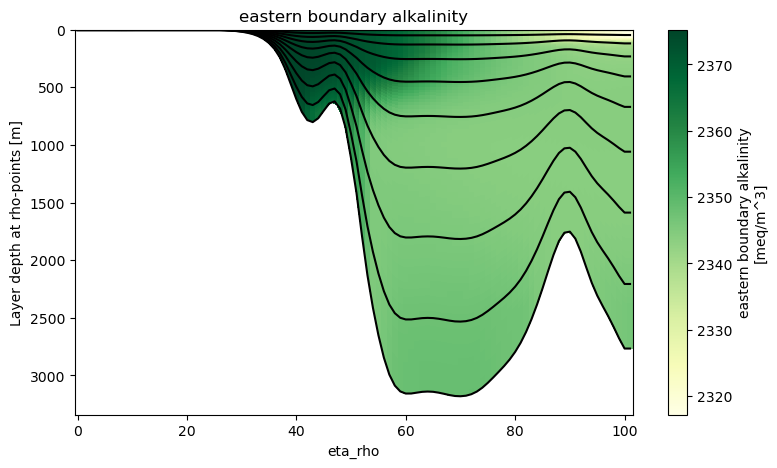

In [22]:
with ProgressBar():
    %time boundary_forcing_with_bgc.plot("ALK_east", time=0, layer_contours=True)

[########################################] | 100% Completed | 57.18 ss
CPU times: user 51.8 s, sys: 479 ms, total: 52.3 s
Wall time: 57.2 s


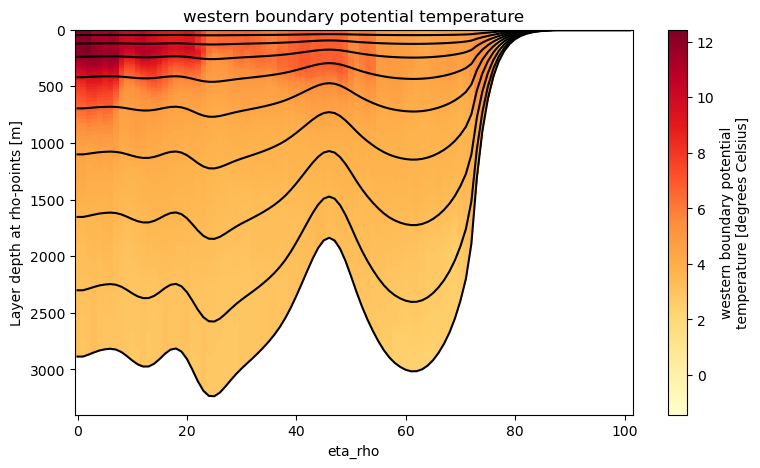

In [23]:
with ProgressBar():
    %time boundary_forcing_with_bgc.plot("temp_west", time=0, layer_contours=True)

## Saving as NetCDF or YAML file
We can now save the dataset as a NetCDF file. We need to specify a prefix for the desired target path.

In [24]:
filepath = "/glade/derecho/scratch/noraloose/forcing/my_boundary_forcing"

`ROMS-Tools` will group the boundary forcing by year and month and append the year and month information to this path. The files will be named with the format `filepath.YYYYMM.nc` if a full month of data is included (at least one data point per day), or `filepath.YYYYMMDD-DD.nc` otherwise.

In [25]:
with ProgressBar():
    %time boundary_forcing_with_bgc.save(filepath)

[########################################] | 100% Completed | 103.11 ms
[########################################] | 100% Completed | 103.45 ms
Saving the following files:
/glade/derecho/scratch/noraloose/forcing/my_boundary_forcing_physics_20120102-03.nc
/glade/derecho/scratch/noraloose/forcing/my_boundary_forcing_bgc_clim.nc
[########################################] | 100% Completed | 576.33 s
CPU times: user 5min 55s, sys: 27 s, total: 6min 22s
Wall time: 9min 37s


We can also export the parameters of our `BoundaryForcing` object to a YAML file.

In [26]:
yaml_filepath = "/glade/derecho/scratch/noraloose/forcing/my_boundary_forcing.yaml"

In [27]:
boundary_forcing_with_bgc.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [28]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev73+dirty
---
BoundaryForcing:
  bgc_source:
    climatology: true
    name: CESM_REGRIDDED
    path: /glade/derecho/scratch/noraloose/roms-tools-data/BGC/CESM-climatology_lowres_regridded.nc
  boundaries:
    east: true
    north: true
    south: true
    west: true
  end_time: '2012-01-04T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  physics_source:
    climatology: false
    name: GLORYS
    path: /glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc
  start_time: '2012-01-02T00:00:00'
Grid:
  N: 100
  center_lat: 61
  center_lon: -21
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: 20
  size_x: 1800
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5



## Creating initial conditions from an existing YAML file

In [29]:
%time the_same_boundary_forcing_with_bgc = BoundaryForcing.from_yaml(yaml_filepath)

CPU times: user 13.9 s, sys: 1.53 s, total: 15.4 s
Wall time: 19.7 s
